This jupyter notebook is here to test properties of the training set (positive-defineteness, symmetry, etc)

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F
from os.path import exists
import scipy.linalg as linalg
import numpy as np
import george # <- I love this name
from scipy.optimize import minimize
import time, math, sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams['figure.facecolor'] = 'white'

sys.path.insert(1, '/home/joeadamo/Research/CovNet')
import CovNet

In [2]:
train_log = False
train_cholesky = False
train_correlation = False
N = 49500
#N = 52500
training_dir = "/home/joeadamo/Research/CovNet/Data/Training-Set/"
save_dir = "/home/joeadamo/Research/CovNet/Plots/"
BOSS_dir = "/home/joeadamo/Research/Data/BOSS-DR12/"
CovaPT_dir = "/home/joeadamo/Research/CovaPT/Example-Data/"

In [3]:
# data and model vectors for chi squared calculations
P_BOSS = np.loadtxt(BOSS_dir+"Cl-BOSS-DR12.dat")
P0_mean = np.loadtxt(CovaPT_dir+'P0_fit_Patchy.dat')
P2_mean = np.loadtxt(CovaPT_dir+'P2_fit_Patchy.dat')

xi_hat = np.concatenate((P_BOSS[1], P_BOSS[2]))
xi_pi = np.concatenate((P0_mean, P2_mean))
x = xi_hat - xi_pi

def chi_squared(C, x):
    P = np.linalg.inv(C)
    return np.matmul(x.T, np.matmul(P, x))

In [4]:
t1 = time.time()
test_data = CovNet.MatrixDataset(training_dir, N, 0, train_log, train_correlation, train_cholesky)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

Done loading in data, took 23.73 s


In [5]:
non_positive_diag = []
non_symmetric = []
non_definete = []; avg_bad = 0
t1 = time.time()
cholesky_fail = 0

min_asym = 10000; max_asym = 0; avg_asym = 0.
# first test the base matrix
for i in range(N):
    C = test_data[i][1].cpu().detach().numpy()
    
    # test diagonal is all positives
    for j in range(C.shape[0]):
        if C[j,j] <= 0:
            non_positive_diag.append(i)
            break
    
    # test assymetry
    C_sym = 0.5*(C + C.T)
    C_asym = 0.5*(C - C.T)
    symmetric_val = np.linalg.norm(C_asym, 2) / np.linalg.norm(C_sym, 2)
    try:
        np.testing.assert_allclose(C, C.T, err_msg="covariance must match transpose")
    except AssertionError:
        non_symmetric.append(i)
        min_asym = min(symmetric_val, min_asym); max_asym = max(symmetric_val, max_asym)
        avg_asym += symmetric_val
    
    # test eigenvalues are all positive
    eigen, v = np.linalg.eig(C)
    if np.all(eigen >= 0.) == False:
        non_definete.append(i)
        avg_bad += len(eigen[(eigen < 0)])
        
    # test that cholesky decomposition works
    try:
        L = np.linalg.cholesky(C)
    except np.linalg.LinAlgError as err:
        cholesky_fail+=1
        
t2 = time.time()
print("Done! took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))
print(len(non_positive_diag), "Matrices have non-positive diagonals")
print(len(non_symmetric), "({:0.2f}%) Matrices are assymetric".format(100.*len(non_symmetric)/N))
print("min / max symmetric val: [{:0.3e}, {:0.3e}] (avg = {:0.3e}".format(min_asym, max_asym, avg_asym / len(non_symmetric)))
print(len(non_definete), "Matrices don't have all positive eigenvalues, avg number of bad eigenvalues:", avg_bad / len(non_definete))
print(cholesky_fail, "Matrices fail to do cholesky decomposition")

Done! took 9 minutes 14.41 seconds
0 Matrices have non-positive diagonals
6644 (13.42%) Matrices are assymetric
min / max symmetric val: [1.637e-17, 9.156e-12] (avg = 8.815e-14
3890 Matrices don't have all positive eigenvalues, avg number of bad eigenvalues: 1.0
3890 Matrices fail to do cholesky decomposition


In [6]:
# # now test the inverse matrix

# non_positive_diag_inv = []
# non_symmetric_inv = []
# non_definete_inv = []
# min_asym = 10000; max_asym = 0; avg_asym = 0.
# t1 = time.time()
# for i in range(int(N*0.8)):
#     C = test_data[i][1].detach().numpy()
#     P = np.linalg.inv(C)
    
#     # test diagonal is all positives
#     for i in range(C.shape[0]):
#         if P[i,i] <= 0:
#             non_positive_diag_inv.append(i)
#             break
    
#     # test assymetry
#     P_sym = 0.5*(P + P.T)
#     P_asym = 0.5*(P - P.T)
#     symmetric_val = np.linalg.norm(P_asym, 2) / np.linalg.norm(P_sym, 2)
#     if abs(symmetric_val) > 1e-14: # this number should be 0 if the matrix is symmetric
#         non_symmetric_inv.append(i)
#         min_asym = min(symmetric_val, min_asym); max_asym = max(symmetric_val, max_asym)
#         avg_asym += symmetric_val
    
#     # test eigenvalues are all positive
#     eigen, v = np.linalg.eig(P)
#     if np.all(eigen > 0.) == False:
#         non_definete_inv.append(i)
        
# t2 = time.time()
# print("Done! took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))
# print(len(non_positive_diag_inv), "Matrices have non-positive diagonals")
# print(len(non_symmetric_inv), "({:0.2f}%) Matrices are assymetric".format(100.*len(non_symmetric_inv)/N))
# print("min / max symmetric val: [{:0.3e}, {:0.3e}] (avg = {:0.3e}".format(min_asym, max_asym, avg_asym / len(non_symmetric)))
# print(len(non_definete_inv), "Matrices don't have all positive eigenvalues")

[ 7.3155075e+01  1.2005943e-01  2.2274092e-02  3.5979397e+00
  1.8609324e+00 -1.9271944e+00]
1


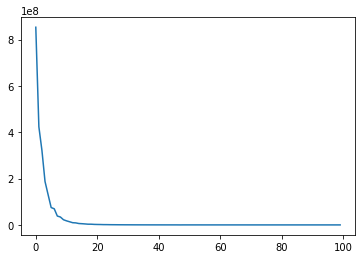

In [7]:
idx = non_definete[0]
C = test_data[idx][1].detach().numpy()
params = test_data[idx][0].detach().numpy()
print(params)
eigen, v = np.linalg.eig(C)
plt.plot(range(len(eigen)), eigen)
print(len(eigen[(eigen < 0)]))

0 0


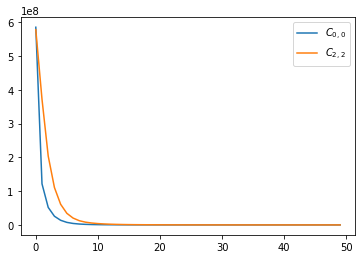

In [8]:
C_00, C_22 = C[:50, :50], C[50:, 50:]
eigen_00, v = np.linalg.eig(C_00)
eigen_22, v = np.linalg.eig(C_22)

print(len(eigen_00[(eigen_00 < 0)]), len(eigen_22[(eigen_22 < 0)]))

plt.plot(range(50), eigen_00, label=r"$C_{0,0}$")
plt.plot(range(50), eigen_22, label=r"$C_{2,2}$")
plt.legend()

Removed no burn in
[0.14233352 0.13129571 0.14492106 ... 0.14494504 0.13211136 0.14114696]


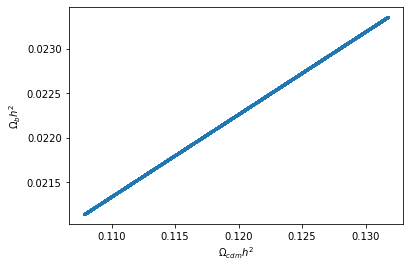

<Figure size 432x288 with 0 Axes>

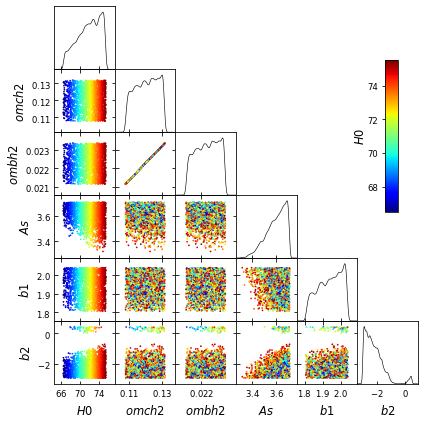

In [21]:
# try to visualize where in the parameter space the non-definite matrices are
params_list = test_data[non_definete][0].detach().numpy()
names = ['H0', 'omch2', 'ombh2', "As", "b1", "b2"]
from getdist import plots, MCSamples
import getdist
# 3D (scatter) triangle plot
plt.scatter(test_data[:][0].detach().numpy()[:,1], test_data[:][0].detach().numpy()[:,2], s=1)
#plt.scatter(params_list[:,1], params_list[:,2], s=1)
plt.xlabel(r"$\Omega_{cdm} h^2$")
plt.ylabel(r"$\Omega_{b} h^2$")
plt.figure()
samples = MCSamples(samples=params_list,names = names, labels = names)
g = plots.get_subplot_plotter(width_inch=6)
# you can adjust the scaling factor if font sizes are too small when
# making many subplots in a fixed size (default=2 would give smaller fonts)
g.settings.scaling_factor = 1
g.triangle_plot(samples, ['H0', 'omch2', 'ombh2', "As", "b1", "b2"], plot_3d_with_param='H0')

omch2 = params_list[:,1]; ombh2 = params_list[:,2]; h = params_list[:,0] / 100
print((omch2 + ombh2))

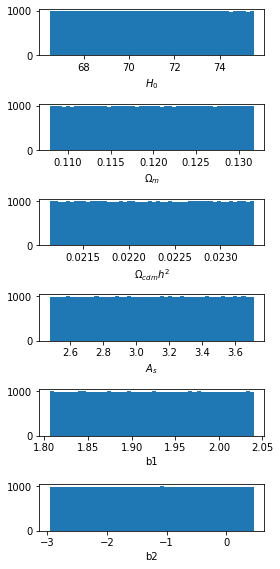

In [20]:
# check that the validation set samples from the entire data range
params = test_data[:][0]
H0 = params[:,0].cpu().detach().numpy()
Omega_m = params[:,1].cpu().detach().numpy()
omch2 = params[:,2].cpu().detach().numpy()
As = params[:,3].cpu().detach().numpy()
b1 = params[:,4].cpu().detach().numpy()
b2 = params[:,5].cpu().detach().numpy()

fig, ax = plt.subplots(6, figsize=(4, 8))
ax[0].hist(H0, bins=50);      ax[0].set_xlabel(r"$H_0$")
ax[1].hist(Omega_m, bins=50); ax[1].set_xlabel(r"$\Omega_m$")
ax[2].hist(omch2, bins=50);   ax[2].set_xlabel(r"$\Omega_{cdm} h^2$")
ax[3].hist(As, bins=50);      ax[3].set_xlabel(r"$A_s$")
ax[4].hist(b1, bins=50);      ax[4].set_xlabel("b1")
ax[5].hist(b2, bins=50);      ax[5].set_xlabel("b2")
plt.tight_layout()

### Data pre-processing code  
The following cells exist to test several different pre-processing methods for the covariance matrix

tensor([ 6.9536e+01,  1.2320e-01,  2.2566e-02,  3.2222e+00,  1.8774e+00,
        -8.0737e-02])
8623


<Figure size 432x288 with 0 Axes>

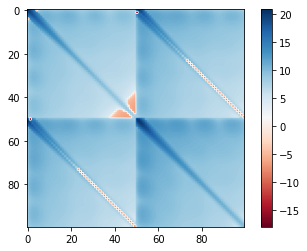

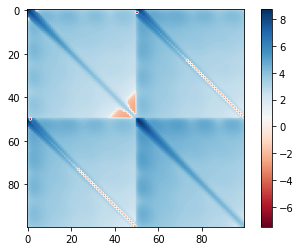

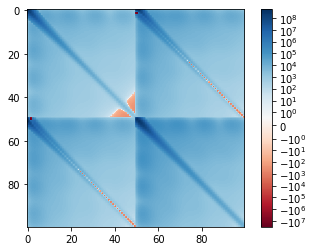

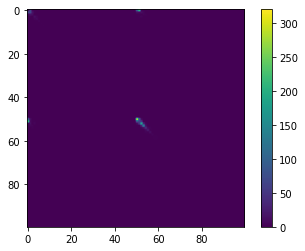

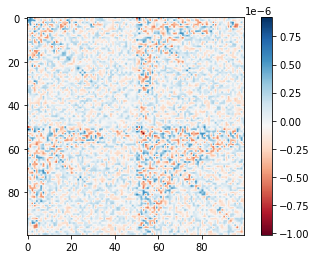

In [7]:
# test the logarithm function and make sure exp(log(C)) = C
idx = np.random.randint(0, N)
C = test_data[idx][1]
params = test_data[idx][0]
print(params)
C_log = CovNet.symmetric_log(C); C_1 = CovNet.symmetric_exp(C_log)
# C and C_1 should be equal, so C - C_1 should just be a matrix of all zeros
idx_bad = np.where(abs((C - C_1) / C) > 1e-14)
print(len(idx_bad[0]))
# plt.imshow(C - C_1, cmap="RdBu")
# cbar = plt.colorbar()

plt.figure()
C_sinh = np.arcsinh(C)
C_2 = np.sinh(C_sinh)
plt.figure()
plt.imshow(C_sinh, cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow(C_log, cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
m = plt.imshow(C_1, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1.))
cbar = plt.colorbar()

plt.figure()
plt.imshow(abs(C_1 - C))
cbar = plt.colorbar()

plt.figure()
plt.imshow((C_1 - C) / C, cmap="RdBu")
cbar = plt.colorbar()

In [19]:
x = torch.linspace(-100, 100, 25, device=CovNet.try_gpu())
x_log = CovNet.symmetric_log(x)
x_1 = CovNet.symmetric_exp(x_log)
print(x)
print(x_log)
print(x_1)
print(x_1 - x)

tensor([-1.0000e+02, -9.1667e+01, -8.3333e+01, -7.5000e+01, -6.6667e+01,
        -5.8333e+01, -5.0000e+01, -4.1667e+01, -3.3333e+01, -2.5000e+01,
        -1.6667e+01, -8.3333e+00, -3.8147e-06,  8.3333e+00,  1.6667e+01,
         2.5000e+01,  3.3333e+01,  4.1667e+01,  5.0000e+01,  5.8333e+01,
         6.6667e+01,  7.5000e+01,  8.3333e+01,  9.1667e+01,  1.0000e+02])
tensor([-2.0043e+00, -1.9669e+00, -1.9260e+00, -1.8808e+00, -1.8304e+00,
        -1.7733e+00, -1.7076e+00, -1.6301e+00, -1.5357e+00, -1.4150e+00,
        -1.2472e+00, -9.7004e-01, -1.6567e-06,  9.7004e-01,  1.2472e+00,
         1.4150e+00,  1.5357e+00,  1.6301e+00,  1.7076e+00,  1.7733e+00,
         1.8304e+00,  1.8808e+00,  1.9260e+00,  1.9669e+00,  2.0043e+00])
tensor([-1.0000e+02, -9.1667e+01, -8.3333e+01, -7.5000e+01, -6.6667e+01,
        -5.8333e+01, -5.0000e+01, -4.1667e+01, -3.3333e+01, -2.5000e+01,
        -1.6667e+01, -8.3333e+00, -3.8147e-06,  8.3333e+00,  1.6667e+01,
         2.5000e+01,  3.3333e+01,  4.1667e+01,  5

In [ ]:
# Convert data in .txt format to .npz format
# training_dir = "/home/joeadamo/Research/Data/Training-Set/"
# new_dir = "/home/joeadamo/Research/Data/Training-Set-New/"
# for idx in range(52500):
    
#     file = training_dir+"CovA-"+f'{idx:05d}'+".txt"
#     f = open(file)
#     header = f.readline()
#     header = f.readline()
#     f.close()
#     header = torch.from_numpy(np.fromstring(header[2:-1], sep=","))
#     params = torch.cat([header[0:4], header[5:]]).detach().numpy()
#     # load in matrix
#     C = np.loadtxt(file, skiprows=2)
#     np.savez(new_dir+"CovA-"+f'{idx:05d}'+".npz", params=params, C=C)
    
#     test = np.load(new_dir+"CovA-"+f'{idx:05d}'+".npz")
#     params_l = test["params"]; C_l = test["C"]
#     assert np.array_equal(params_l, params) and np.array_equal(C, C_l)
# print("Done!")

In [21]:
# Test Cholesky decomposition
train_cholesky = True
idx = np.random.randint(0, N)
C = test_data[idx][1].view(1,100,100)
#C = symmetric_log(C)

if train_cholesky:
    C = torch.linalg.cholesky(C)
B = C.shape[0]
L1 = torch.tril(C)[:,:,:50]; L2 = torch.tril(C)[:,:,50:]
L1 = torch.cat((torch.zeros((B,1, 50), device=CovNet.try_gpu()), L1), 1)
L2 = torch.cat((torch.flip(L2, [1,2]), torch.zeros((B,1, 50), device=try_gpu())),1)
C_half = L1 + L2

C_full = torch.zeros((B, 100,100), device=CovNet.try_gpu())
C_full[:,:,:50] = C_full[:,:,:50] + C_half[:,1:,:]
C_full[:,:,50:] = C_full[:,:,50:] + torch.flip(C_half[:,:-1,:], [1,2])
L = torch.tril(C_full); U = torch.transpose(torch.tril(C_full, diagonal=-1),1,2)
if train_cholesky: # <- undo the cholesky decomposition
    C_full = torch.matmul(L, torch.transpose(L, 1, 2))
else:
    C_full = L + U
    
L = L.view(100,100); C = C.view(100,100); C_half = C_half.view(101,50); C_full = C_full.view(100,100)
chisq_true = chi_squared(C.cpu().detach().numpy(), x)
chisq_pred = chi_squared(C_full.cpu().detach().numpy(), x)
print(chisq_true, chisq_pred)

plt.imshow((symmetric_log(C).cpu()), cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow((symmetric_log(C_half).cpu()), cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow((symmetric_log(C_full).cpu()), cmap="RdBu")
cbar = plt.colorbar()
# try training the quadrants independently

plt.figure()
plt.imshow(abs(torch.matmul(C, torch.t(C)) - C_full).cpu())
cbar = plt.colorbar()

_LinAlgError: torch.linalg_cholesky: (Batch element 0): The factorization could not be completed because the input is not positive-definite (the leading minor of order 5 is not positive-definite).

idx =  33576


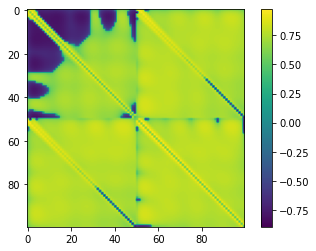

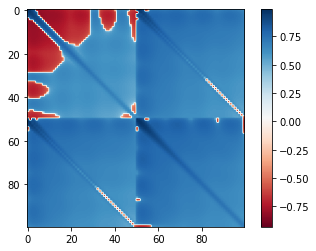

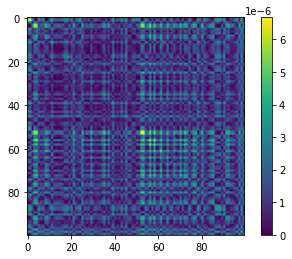

In [26]:
# test code to convert to / from correlation matrix
idx = np.random.randint(0, N)
print("idx = ", idx)
C = test_data[idx][1].view(1, 100, 100)
D = torch.sqrt(torch.diagonal(C,0,1,2))
D = torch.diag_embed(D)
Corr = torch.matmul(torch.linalg.inv(D), torch.matmul(C, torch.linalg.inv(D)))
Corr = Corr + (CovNet.symmetric_log(D) - torch.eye(100))

plt.figure()
plt.imshow(Corr.view(100,100).cpu())
cbar = plt.colorbar()

D_1 = torch.diag_embed(torch.diagonal(Corr,0,1,2))
Corr = Corr - (D_1) + torch.eye(100)
D_1 = CovNet.symmetric_exp(D_1)
C_1 = torch.matmul(D_1, torch.matmul(Corr, D_1))

plt.figure()
plt.imshow(CovNet.symmetric_log(C_1).view(100,100).cpu(), cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow(abs(C_1 - C).view(100,100).cpu())
cbar = plt.colorbar()

idx =  1293
torch.Size([50, 50]) torch.Size([50, 50]) torch.Size([50, 50])


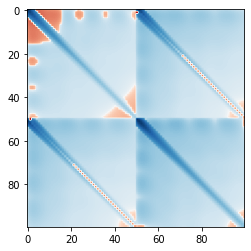

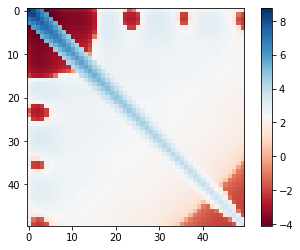

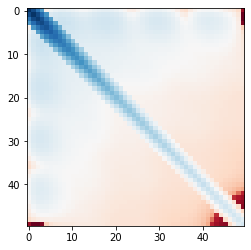

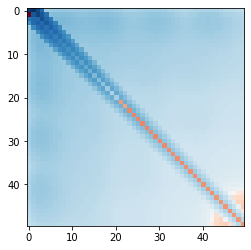

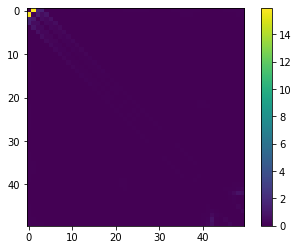

In [24]:
# test code for splitting up matrix into quadrands
idx = np.random.randint(0, int(N*0.1))
print("idx = ", idx)
C = test_data[idx][1].view(1, 100, 100)
quad1 = C[:,:50,:50]
quad2 = C[:,50:,50:]
quad3 = C[:,:50,50:]

C = C.view(100,100); quad1 = quad1.view(50,50); quad2 = quad2.view(50,50); quad3 = quad3.view(50,50)
plt.imshow(C.cpu().detach().numpy(), cmap="RdBu")

print(quad1.shape, quad2.shape, quad3.shape)
plt.figure()
plt.imshow(quad1.cpu().detach().numpy(), cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow(quad2.cpu().detach().numpy(), cmap="RdBu")

plt.figure()
plt.imshow(quad3.cpu().detach().numpy(), cmap="RdBu")

plt.figure()
plt.imshow(abs(quad3 - torch.t(quad3)).cpu().detach().numpy())
cbar = plt.colorbar()